In [1]:
import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization
import tensorflow.keras.backend as K
from math import isnan


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] ['faces\\data\\ellie\\10_0.jpg', 'faces\\data\\ellie\\14_0.jpg', 'faces\\data\\ellie\\1_0.jpg', 'faces\\data\\ellie\\21_0.jpg', 'faces\\data\\ellie\\24_0.jpg', 'faces\\data\\ellie\\27_0.jpg', 'faces\\data\\ellie\\29_1.jpg', 'faces\\data\\ellie\\2_0.jpg', 'faces\\data\\ellie\\30_0.jpg', 'faces\\data\\ellie\\33_0.jpg', 'faces\\data\\ellie\\3_0.jpg', 'faces\\data\\ellie\\40_0.jpg', 'faces\\data\\ellie\\41_1.jpg', 'faces\\data\\ellie\\42_0.jpg', 'faces\\data\\ellie\\43_0.jpg', 'faces\\data\\ellie\\45_0.jpg', 'faces\\data\\ellie\\46_0.jpg', 'faces\\data\\ellie\\47_0.jpg', 'faces\\data\\ellie\\48_0.jpg', 'faces\\data\\ellie\\50_0.jpg', 'faces\\data\\ellie\\5_0.jpg', 'faces\\data\\ellie\\7_0.jpg', 'faces\\data\\ellie\\8_0.jpg', 'faces\\data\\ellie\\9_0.jpg', 'faces\\data\\ellie\\ellie.jpg', 'faces\\data\\m

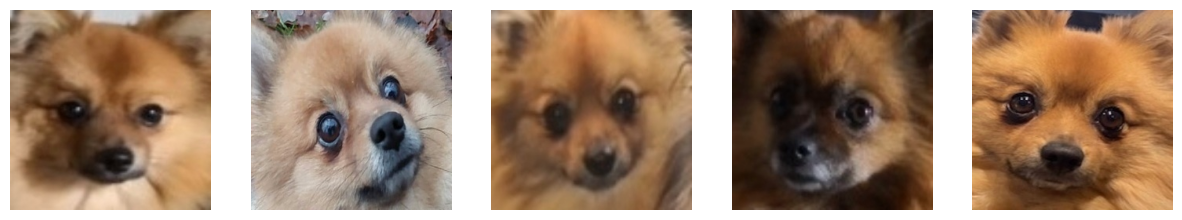

In [2]:
#load dataset
dataPath = "faces\\data"
X = []
y = []

imageClass = 0
for folder in os.listdir(dataPath):
    for file in os.listdir(dataPath + "\\" + folder):
        X.append(os.path.join(dataPath, folder, file))
        y.append(imageClass)
    imageClass += 1

print(y, X)

#show 5 images on same plot
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    j = np.random.randint(len(X))
    axs[i].imshow(cv2.imread(X[j]))
    axs[i].axis('off')
plt.show()


#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
#make np arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [3]:
alpha = 0.3

def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

In [4]:
embeddings = 128
imgSize = (256, 256, 3)

inputs = Input(shape=imgSize)

x = Conv2D(16, (7, 7), (2, 2), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((3,3))(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

# Dense layer with 32 units and no bias
x = Dense(embeddings, use_bias=False)(x)

# L2 normalization
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)


model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet, optimizer='adam', metrics=[triplet_acc])

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 2352        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 42, 42, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
#----------------------UTILS----------------------#

#data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    fill_mode='nearest',
    channel_shift_range = 0.1
)

#loads im from filenames to np array
def load_images(filenames):
    h,w,c = imgSize
    images = np.empty((len(filenames),h,w,c))
    for i,f in enumerate(filenames):
        images[i] = sk.io.imread(f)/255.0
    return images


 #uses datagen to transform images
def transform(images, datagen):
    for i in datagen.flow(images, batch_size=len(images), shuffle=False):
        return i

#creates soft triplets from filenames and labels
def generate_soft_triplets(filenames,labels,triplets_count = 21 * 3): 
    X_triplet = []
    y_triplet = np.empty(triplets_count)
    classes = np.unique(labels)
    for i in range(0,triplets_count,3):
        # Pick a class and chose two pictures from this class
        picked_class = classes[np.random.randint(len(classes))]
        where_picked_class = np.equal(labels,picked_class)

        picked_files = filenames[where_picked_class]
        picked_labels = labels[where_picked_class]

        #picks anchor and positive image from same class
        index_anchor = np.random.randint(len(picked_files))
        index_positive = np.random.randint(len(picked_files))

        while index_anchor == index_positive:
            index_positive = np.random.randint(len(picked_files))

        X_triplet += [picked_files[index_positive]]
        X_triplet += [picked_files[index_anchor]]
        y_triplet[i] = picked_labels[index_positive]
        y_triplet[i+1] = picked_labels[index_anchor]

        # Pick a class for the negative picture
        class_negative = classes[np.random.randint(len(classes))]
        #check if not same class
        while class_negative==picked_class:
            class_negative = classes[np.random.randint(len(classes))]

        where_picked_class = np.equal(labels,class_negative)
        picked_files_negative = filenames[where_picked_class]
        picked_labels_negative = labels[where_picked_class]

        #picks negative image from different class
        index_negative = np.random.randint(len(picked_files_negative))

        X_triplet += [picked_files_negative[index_negative]]
        y_triplet[i+2] = picked_labels_negative[index_negative]
        
    return X_triplet, y_triplet

#generates triplets, transforms and loads images
def image_generator(filenames, labels, batch_size=63, use_aug=True, datagen=datagen):
    while True:
        X_triplet, y_triplet = generate_soft_triplets(filenames, labels, batch_size)
        X_triplet = load_images(X_triplet)
        if use_aug:
            X_triplet = transform(X_triplet, datagen)
        yield (X_triplet, y_triplet)

#generates hard triplets from filenames, labels and predictions
def generate_adaptive_hard_triplets(filenames, labels, prediction, triplets_count=21*3, use_negative=True, use_positive=True):
    
    # Check if triplets_count is a multiple of 3
    assert triplets_count%3 == 0
    
    classes = np.sort(np.unique(labels))
    triplets = []
    y_triplets = np.empty(triplets_count)
    pred_triplets = np.empty((triplets_count,prediction.shape[-1]))

    for i in range(0, triplets_count, 3): #3 is the step size
        picked_class = np.equal(labels,classes[np.random.randint(len(classes))])
        picked_files = filenames[picked_class]
        picked_labels = labels[picked_class]
        
        # Chooses the anchor image among this class randomly
        index_anchor = np.random.randint(len(picked_labels))
        
        
        # Computes the distance between the chosen image and the rest of the class
        if use_positive: 
            #finds the index of the image in the class that is the most dissimilar to the anchor image
            dist_class = np.sum(np.square(prediction[picked_class]-prediction[picked_class][index_anchor]),axis=-1)
            index_positive = np.argmax(dist_class)
        else:
            #finds a random image in the class that is not the anchor image
            index_positive = np.random.randint(len(picked_labels))
            while index_anchor==index_positive:
                index_positive = np.random.randint(len(picked_labels))
               
        
        triplets += [picked_files[index_anchor]]
        y_triplets[i] = picked_labels[index_anchor]
        pred_triplets[i] = prediction[picked_class][index_anchor]
        triplets += [picked_files[index_positive]]
        y_triplets[i+1] = picked_labels[index_positive]
        pred_triplets[i+1] = prediction[picked_class][index_positive]
        
        # Computes the distance between the chosen image and the rest of the other classes
        other_classes = np.logical_not(picked_class)
        
        if use_negative:
            #finds the index of the image in the other classes that is the most similar to the anchor image
            dist_other = np.sum(np.square(prediction[other_classes]-prediction[picked_class][index_anchor]),axis=-1)
            index_negative = np.argmin(dist_other)
        else:
            index_negative = np.random.randint(len(filenames[other_classes]))
            
        triplets += [filenames[other_classes][index_negative]]
        y_triplets[i+2] = labels[other_classes][index_negative]
        pred_triplets[i+2] = prediction[other_classes][index_negative]

    return np.array(triplets), y_triplets, pred_triplets

#generates predictions, and loads images
def predict_generator(filenames, batch_size=32):
    for i in range(0,len(filenames),batch_size):
        images_batch = load_images(filenames[i:i+batch_size])
        yield images_batch 
        #difference between yield and return is that yield returns a generator object

#generator to select online hard triplets for training
#online means that the hard triplets are selected from the current batch of images instead of the whole dataset
def online_adaptive_hard_image_generator(filenames, labels, model, loss, batch_size=63, use_aug=True, datagen=datagen):  

    hard_triplet_ratio = 0
    hard_triplets_count = 0

    while True:
        classes = np.unique(labels)
        prediction = model.predict(predict_generator(filenames, 32), steps=int(np.ceil(len(filenames)/32)))

        X_triplet_hard, y_triplet_hard, predict_hard = generate_adaptive_hard_triplets(filenames, labels, prediction, hard_triplets_count*3, use_negative=True, use_positive=True)
        X_triplet_soft, y_triplet_soft, predict_soft = generate_adaptive_hard_triplets(filenames, labels, prediction, batch_size-hard_triplets_count*3, use_negative=False, use_positive=False)

        X_triplet = np.append(X_triplet_hard,X_triplet_soft)
        y_triplet = np.append(y_triplet_hard,y_triplet_soft)

        prediction = np.append(predict_hard, predict_soft, axis=0)
        
        hard_triplet_ratio = np.exp(-loss * 10 / batch_size)

        #isnan is used to check if hard_triplet_ratio is nan
        if isnan(hard_triplet_ratio):
            hard_triplet_ratio = 0
        hard_triplets_count = int(batch_size//3 * hard_triplet_ratio)
        
        i_triplet = load_images(X_triplet)
        if use_aug:
            i_triplet = transform(i_triplet, datagen)
            
        yield (i_triplet, y_triplet)

In [6]:
#training
epochs = 50
batch_size = 3*6
max_step = 100


loss = []
acc = []
best_val_loss = 100
val_loss = []
val_acc = []

#test
max_val_steps = 30

mean_val_loss = 0
mean_val_acc = 0
total_val_loss = 0
total_val_acc = 0

savePath = "models\\best\\"
if not os.path.exists(savePath):
    os.makedirs(savePath)
previous_models = os.listdir(savePath)
savePath += "model_best" + str(len(previous_models)) + ".h5"



for epoch in range(epochs):
    step = 1
    total_loss = 0
    total_acc = 0
    mean_loss = 0
    mean_acc = 0
    for images_batch,labels_batch in online_adaptive_hard_image_generator(X_train, y_train, model, mean_acc, batch_size):
        
        results = model.train_on_batch(images_batch,labels_batch)
        total_loss += results[0]
        mean_loss = total_loss/step
        total_acc += results[1]
        mean_acc = total_acc/step

        #sigmoid to calculate the ratio of hard triplets
        sigmoid_input = -10*mean_acc+5.3
        sigmoid_output = 1.2/(1+np.exp(sigmoid_input))
        hard_triplet_ratio = max(0, sigmoid_output - 0.19)

        if step == max_step:
            break

        step+=1
    
    loss += [mean_loss]
    acc += [mean_acc]

    #after training 100 steps we validate the model
    #validation 
    step = 1
    
    total_val_loss = 0
    mean_val_loss = 0

    total_val_acc = 0
    mean_val_acc = 0

    #30 steps on test set using soft triplets
    for images_batch,labels_batch in image_generator(X_test,y_test,batch_size,use_aug=False):
        results = model.test_on_batch(images_batch,labels_batch)
        total_val_loss += results[0]
        mean_val_loss = total_val_loss/step
        total_val_acc += results[1]
        mean_val_acc = total_val_acc/step

        if step == max_val_steps:
            break
        step+=1

    print("epoch: " + str(epoch) + "/" + str(epochs) + " Val_loss: " + str(mean_val_loss) +  " Val_acc: " + str(mean_val_acc))
    if mean_val_loss < best_val_loss:
        print("saving model at epoch: " + str(epoch) + " with val_loss: " + str(mean_val_loss) + " and val_acc: " + str(mean_val_acc))
        model.save(savePath)
        best_val_loss = mean_val_loss

    val_loss += [mean_val_loss]
    val_acc += [mean_val_acc]

    
    


epoch: 0/50 Val_loss: 1.3001954197883605 Val_acc: 0.3555555631717046
saving model at epoch: 0 with val_loss: 1.3001954197883605 and val_acc: 0.3555555631717046


c:\Users\viers\anaconda3\envs\DeepLearning\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


epoch: 1/50 Val_loss: 1.201376168181499 Val_acc: 0.5611111149191856
saving model at epoch: 1 with val_loss: 1.201376168181499 and val_acc: 0.5611111149191856
epoch: 2/50 Val_loss: 3.1790704766909283 Val_acc: 0.555555559694767
epoch: 3/50 Val_loss: 4.222109667460123 Val_acc: 0.4000000059604645
epoch: 4/50 Val_loss: 2.307957265774409 Val_acc: 0.6222222238779068
epoch: 5/50 Val_loss: 0.9539719154437383 Val_acc: 0.7833333293596904
saving model at epoch: 5 with val_loss: 0.9539719154437383 and val_acc: 0.7833333293596904
epoch: 6/50 Val_loss: 0.9046804204583168 Val_acc: 0.8444444417953492
saving model at epoch: 6 with val_loss: 0.9046804204583168 and val_acc: 0.8444444417953492
epoch: 7/50 Val_loss: 0.4399417320887248 Val_acc: 0.9333333293596904
saving model at epoch: 7 with val_loss: 0.4399417320887248 and val_acc: 0.9333333293596904
epoch: 8/50 Val_loss: 1.7987014586726824 Val_acc: 0.7888888825972875
epoch: 9/50 Val_loss: 1.0029959162076314 Val_acc: 0.7833333243926366
epoch: 10/50 Val_los

In [7]:
#create a database of each dogs face using the training images

def getFileNameForEachLabel(X_train,y_train, label):
    filenamesLabel = []
    for i in range(len(y_train)):
        if y_train[i] == label:
            filenamesLabel.append(X_train[i])
    return filenamesLabel

LabelsEllie = getFileNameForEachLabel(X_train,y_train, 0)
LabelsMarley = getFileNameForEachLabel(X_train,y_train, 1)
LabelsMuchu = getFileNameForEachLabel(X_train,y_train, 2)

def load_image(filename):
    image = cv2.imread(filename)
    image = image.reshape(1,256,256,3)
    image = image.astype('float32')/255.0
    return image

#creates a dictionary with the name of the dog as the key and the face embedding as the value
def create_database(model, filesPerLabel,label):
    database = {}
    names = ['Ellie', 'Marley', 'Muchu']
    label = names[label]
    for i in range(len(filesPerLabel)):
        database[label] = model.predict(load_image(filesPerLabel[i]))
    return database
    
databaseEllie = create_database(model, LabelsEllie, 0)
databaseMarley = create_database(model, LabelsMarley, 1)
databaseMuchu = create_database(model, LabelsMuchu, 2)
print(databaseEllie)



{'Ellie': array([[ 0.00943516,  0.08711621, -0.04827403, -0.09217978, -0.01519147,
        -0.01767311,  0.17258736,  0.06497498,  0.14671367, -0.01148752,
         0.07993888,  0.0847381 , -0.1302862 ,  0.05237988,  0.01553455,
         0.03959772, -0.01394758,  0.02148246, -0.04984864, -0.11393782,
        -0.01347008, -0.12914416, -0.06599418, -0.0659029 , -0.14271782,
        -0.15043771, -0.08642315,  0.06422983, -0.08025707, -0.06589245,
        -0.07284617,  0.07055018, -0.03932501, -0.00176974, -0.03554215,
        -0.02602899, -0.08418822,  0.0446626 ,  0.03578911,  0.07307725,
         0.1260241 , -0.0800631 , -0.19849819,  0.02098716, -0.01783622,
        -0.21792714, -0.04980868,  0.01841659,  0.08175986,  0.16898973,
         0.01894733,  0.0420364 , -0.05237845, -0.10435041, -0.0815786 ,
         0.08438025,  0.00345815, -0.05846797,  0.16472547, -0.17267495,
        -0.14042492, -0.07141104,  0.00801418,  0.00773952, -0.002739  ,
        -0.09321232, -0.08099827,  0.0267

(1.7870005, 'Ellie')
(0.10041188, 'Marley')
(1.7356303, 'Muchu')
Marley


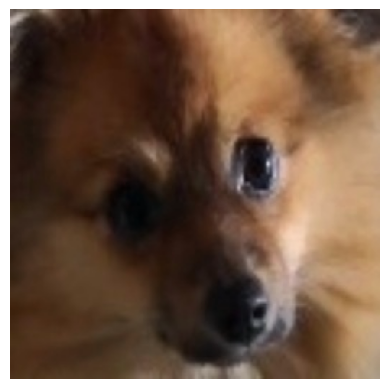

In [8]:
#verify test images on databases

def verify(image_path, database, model):
    encoding = model.predict(load_image(image_path))
    min_dist = float('inf')
    identity = None
    for name, db_enc in database.items():
        dist = np.linalg.norm(encoding - db_enc)
        if dist < min_dist:
            min_dist = dist
            identity = name         
    return min_dist, identity

image = load_image(X_test[0])
print(verify(X_test[0], databaseEllie, model))
print(verify(X_test[0], databaseMarley, model))
print(verify(X_test[0], databaseMuchu, model))

#plot img   
plt.imshow(image[0])
plt.axis("off")

def classify(image_path, model):
    distances = {}
    for database in [databaseEllie, databaseMarley, databaseMuchu]:
        dist, identity = verify(image_path, database, model)
        distances[identity] = dist
    return min(distances, key=distances.get)

print(classify(X_test[0], model))
    


(1.7870005, 'Ellie')
(0.10041188, 'Marley')
(1.7356303, 'Muchu')


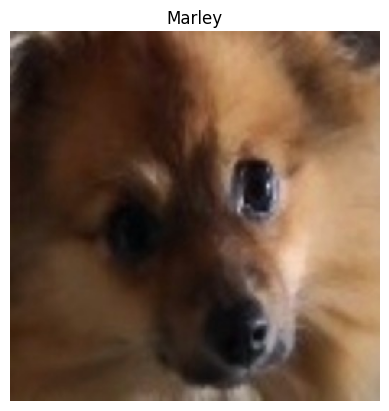

(1.8268188, 'Ellie')
(0.028382914, 'Marley')
(1.7876253, 'Muchu')


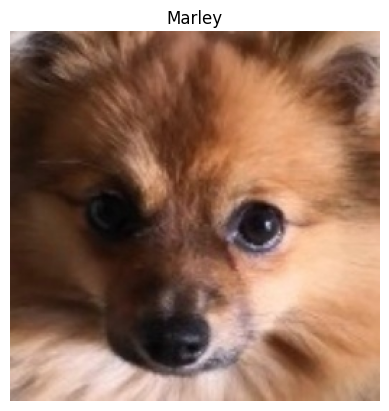

(0.34859732, 'Ellie')
(1.7690133, 'Marley')
(0.6307057, 'Muchu')


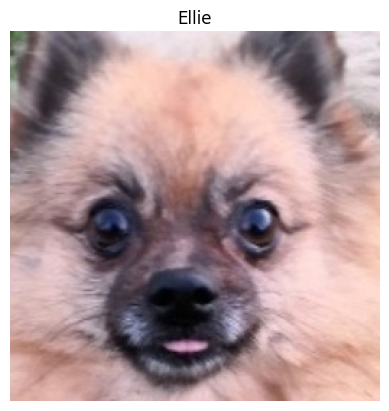

(0.10246142, 'Ellie')
(1.7986168, 'Marley')
(0.20504345, 'Muchu')


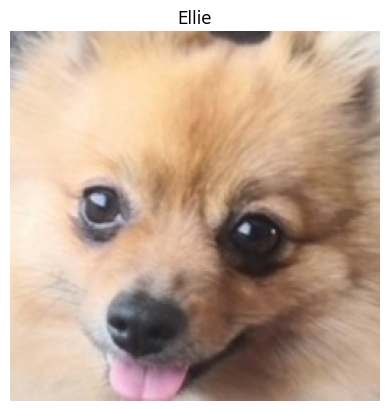

(1.718799, 'Ellie')
(0.24733832, 'Marley')
(1.6557688, 'Muchu')


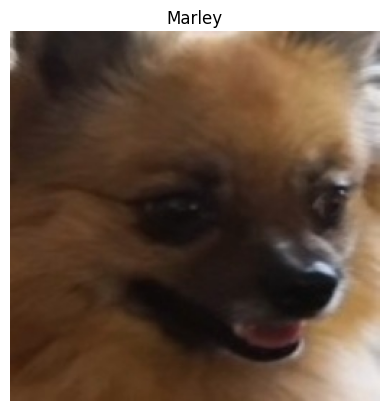

(1.7769499, 'Ellie')
(0.13897577, 'Marley')
(1.72004, 'Muchu')


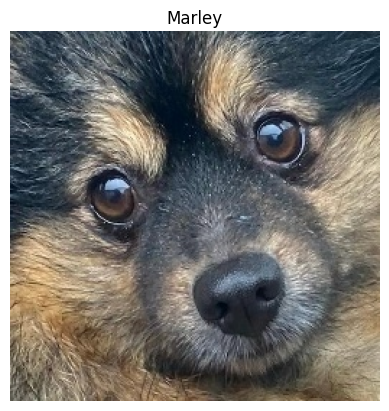

(0.065981805, 'Ellie')
(1.799307, 'Marley')
(0.3494302, 'Muchu')


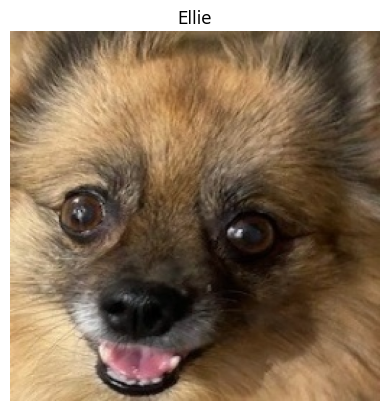

(0.69103056, 'Ellie')
(1.4909742, 'Marley')
(0.505897, 'Muchu')


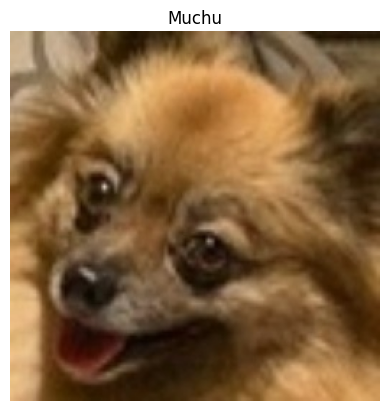

(1.805225, 'Ellie')
(0.036667928, 'Marley')
(1.7702681, 'Muchu')


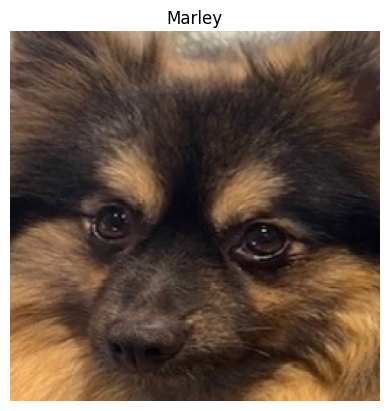

(0.16994402, 'Ellie')
(1.7907149, 'Marley')
(0.13576154, 'Muchu')


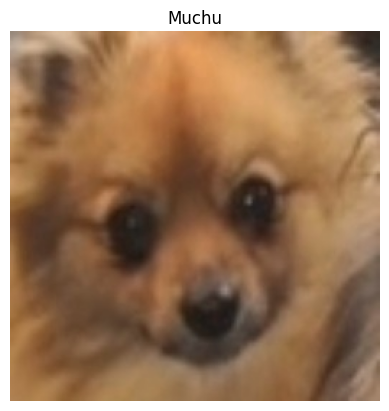

(0.28892803, 'Ellie')
(1.7113084, 'Marley')
(0.18772532, 'Muchu')


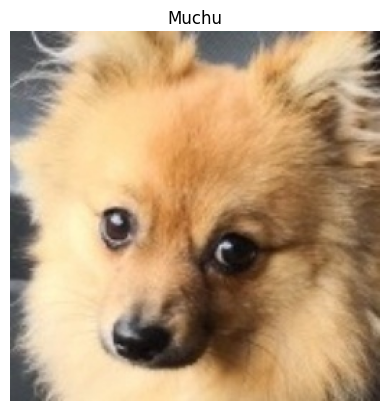

(0.3389786, 'Ellie')
(1.706691, 'Marley')
(0.1585499, 'Muchu')


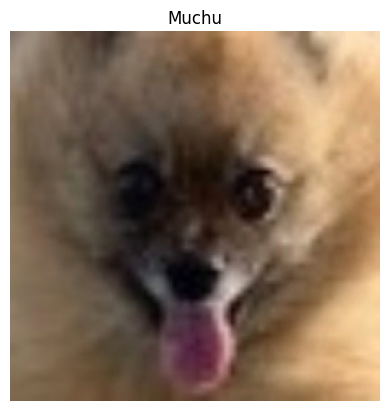

(0.43160573, 'Ellie')
(1.7135848, 'Marley')
(0.15317886, 'Muchu')


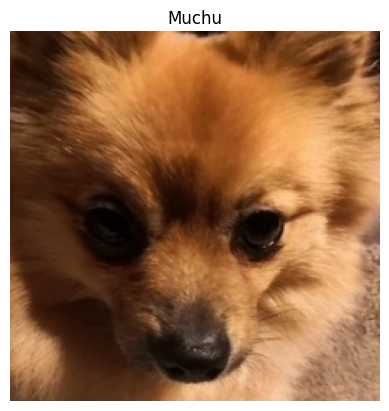

In [9]:
#test on some images

for file in X_test:
    print(verify(file, databaseEllie, model))
    print(verify(file, databaseMarley, model))
    print(verify(file, databaseMuchu, model))

    #print(classify(file, model))
    image = load_image(file)
    plt.imshow(image[0])
    plt.title(classify(file, model))
    plt.axis("off")
    plt.show()


(1.6937546, 'Ellie')
(0.5342089, 'Marley')
(1.6195832, 'Muchu')


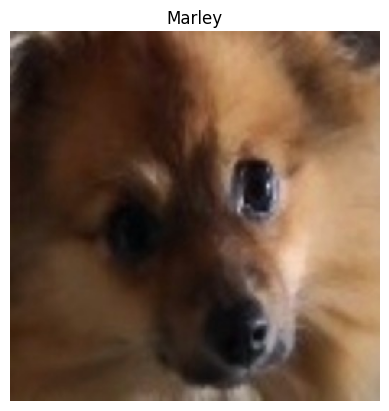

(1.7332488, 'Ellie')
(0.43318254, 'Marley')
(1.6700091, 'Muchu')


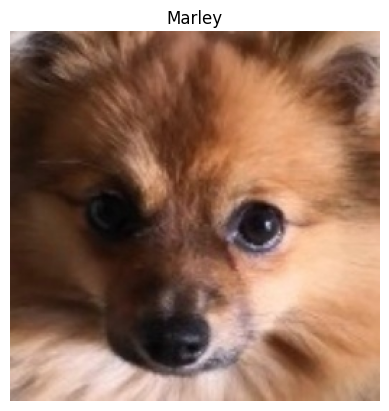

(0.50707746, 'Ellie')
(1.6998578, 'Marley')
(0.6704354, 'Muchu')


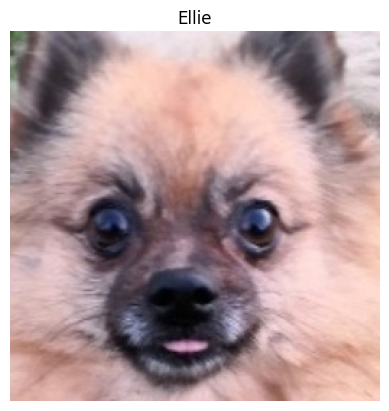

(1.222825, 'Ellie')
(1.1221311, 'Marley')
(1.151198, 'Muchu')


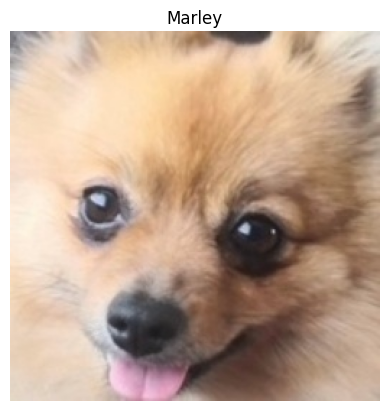

(1.6922779, 'Ellie')
(0.50753075, 'Marley')
(1.6243436, 'Muchu')


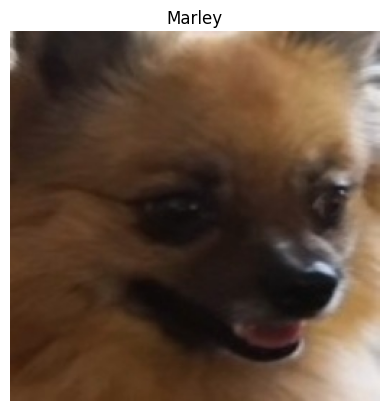

(1.8259325, 'Ellie')
(0.3024095, 'Marley')
(1.7880573, 'Muchu')


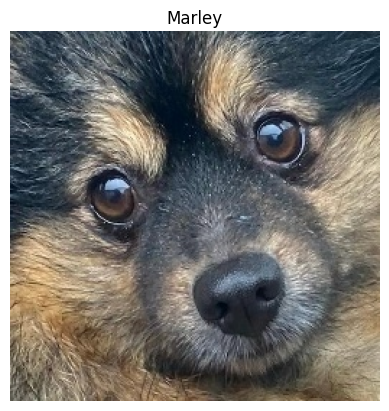

(1.721518, 'Ellie')
(0.4371597, 'Marley')
(1.6595663, 'Muchu')


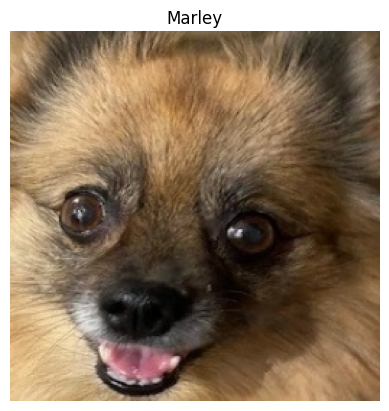

(1.7743155, 'Ellie')
(0.38299426, 'Marley')
(1.7136623, 'Muchu')


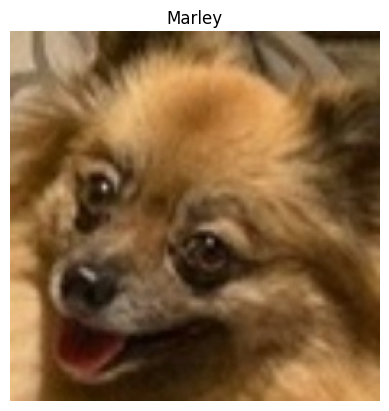

(0.9384898, 'Ellie')
(1.4935368, 'Marley')
(0.84862757, 'Muchu')


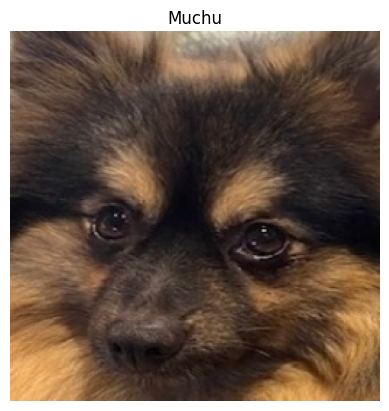

(1.4168628, 'Ellie')
(0.9131651, 'Marley')
(1.33625, 'Muchu')


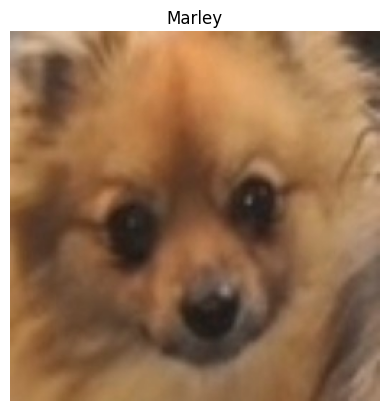

(1.7012603, 'Ellie')
(0.5119829, 'Marley')
(1.6285369, 'Muchu')


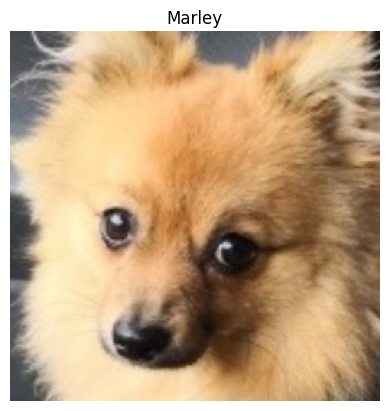

(1.288362, 'Ellie')
(1.0991836, 'Marley')
(1.1987823, 'Muchu')


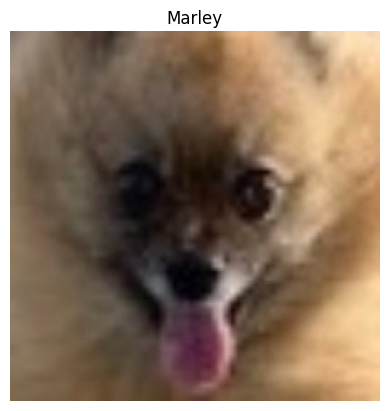

(1.3252935, 'Ellie')
(1.2103909, 'Marley')
(1.2006886, 'Muchu')


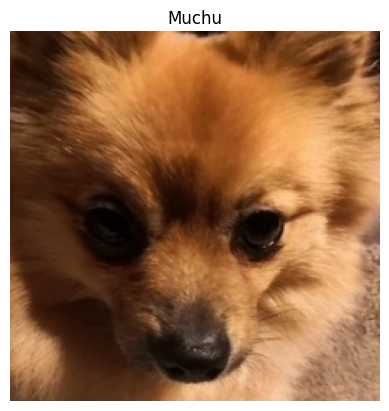

In [10]:

#load model
model.load_weights(savePath)
for file in X_test:
    print(verify(file, databaseEllie, model))
    print(verify(file, databaseMarley, model))
    print(verify(file, databaseMuchu, model))

    #print(classify(file, model))
    image = load_image(file)
    plt.imshow(image[0])
    plt.title(classify(file, model))
    plt.axis("off")
    plt.show()
